In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

import wrf

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [2]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# Open the NetCDF file
ncfile_orig = os.path.join(pvlib_abspath, 'data', 'wrfout_d01_2011-01-24_01:00:00')
ncdata = netCDF4.Dataset(ncfile_orig)

In [8]:
# Define the time indicies (i.e., hours) the default is range(0,24)
time_indicies = range(1,24)

/Users/swardy9230/opt/anaconda3/envs/runwrf/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


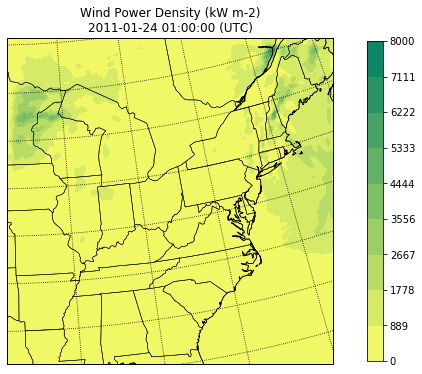

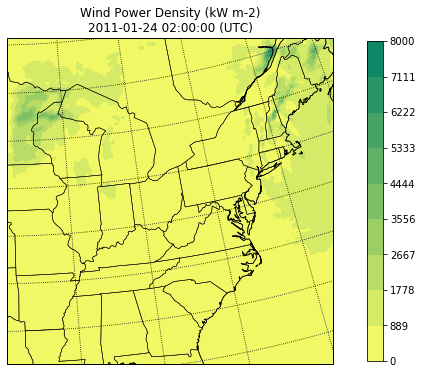

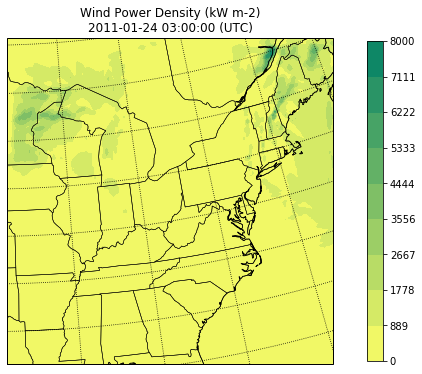

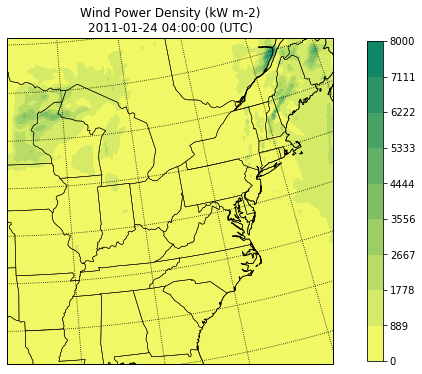

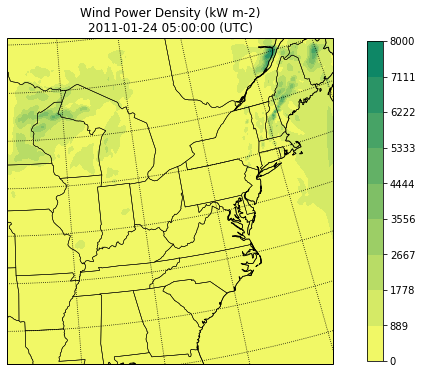

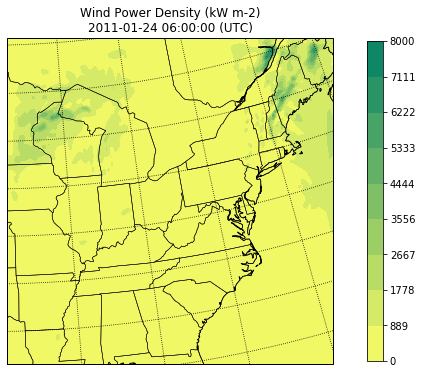

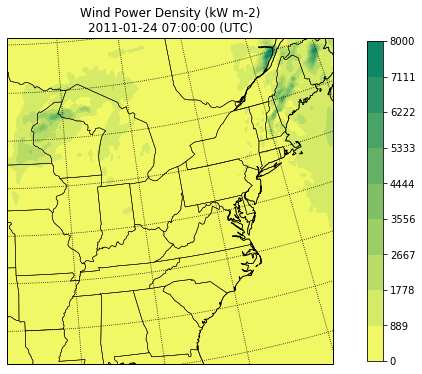

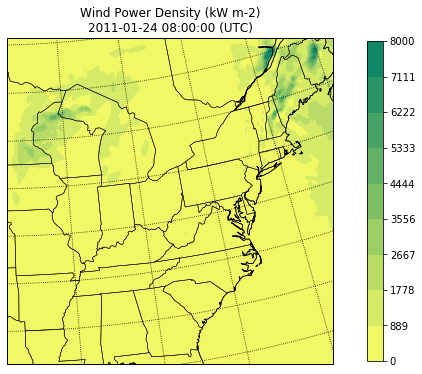

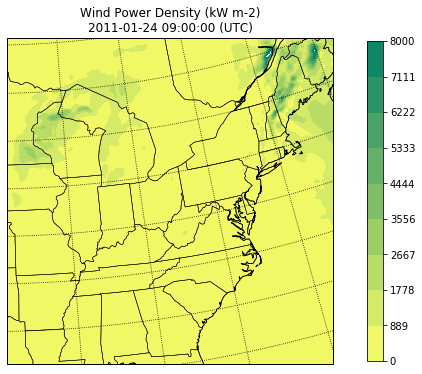

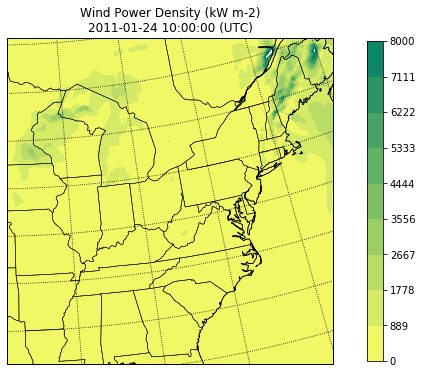

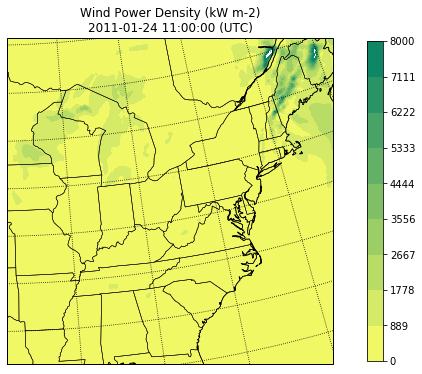

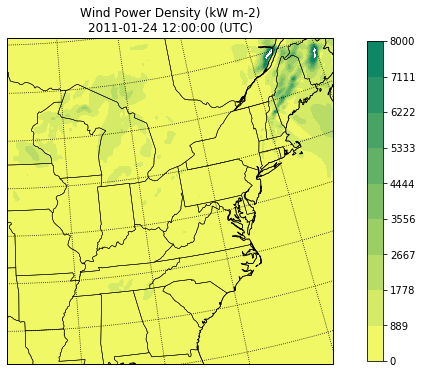

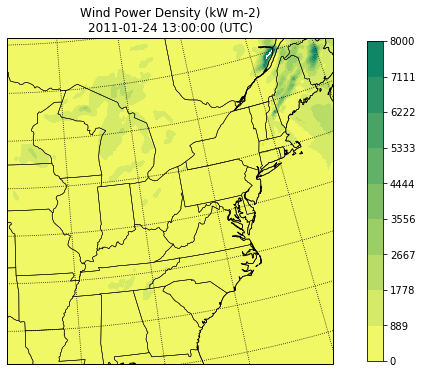

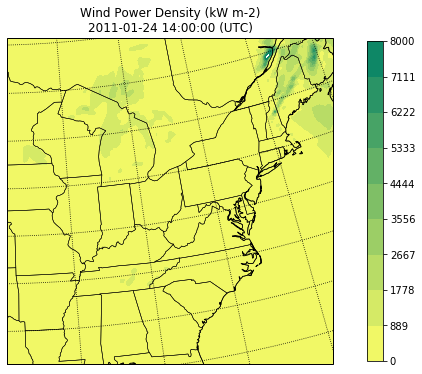

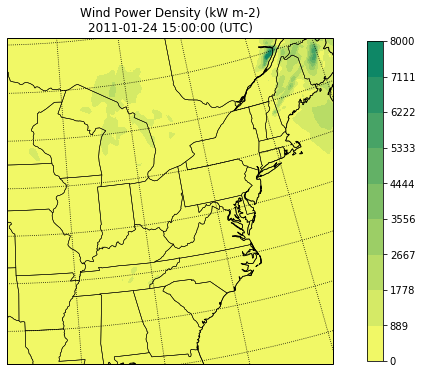

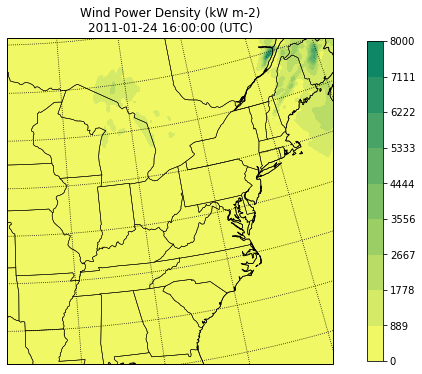

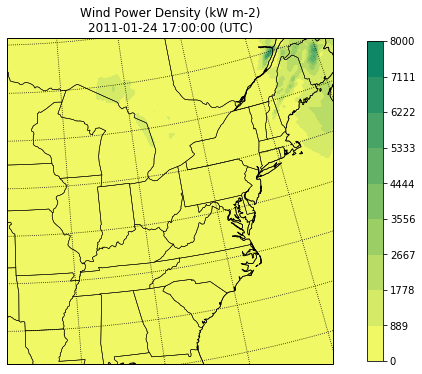

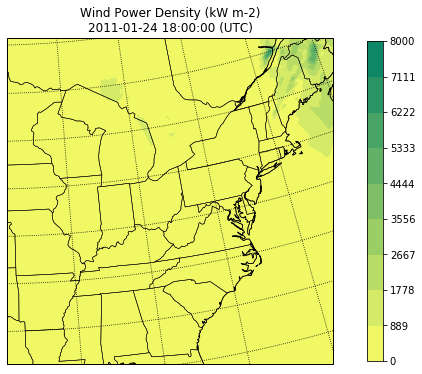

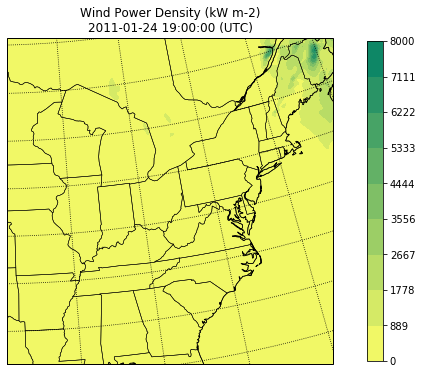

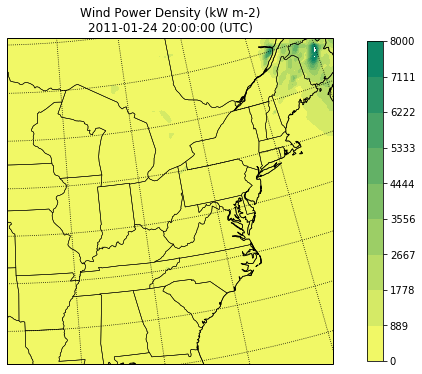

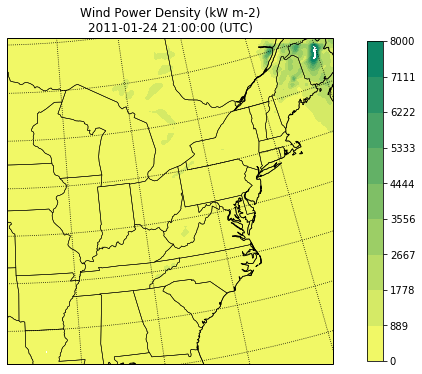

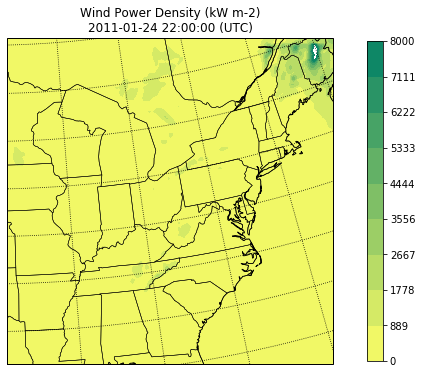

In [10]:
# Get the desired variable(s)
for tidx in time_indicies:
    timestr = f'2011-01-24 {str(tidx).zfill(2)}:00:00'
    height = getvar(ncdata, "height_agl", timeidx=tidx, units='m')
    wspd = getvar(ncdata, 'wspd_wdir', timeidx=tidx, units='m s-1')[0,:]

    #  Interpolate wind speeds to 100m height
    wspd_100 = wrf.interplevel(wspd, height, 100)

    # Calculate wind power per square meter
    fm = WRF()
    air_density = 1000 
    wind_power = 0.5 * (wspd_100) ** 3 * air_density / 1000

    # Smooth the variable if it tends to be noisy 
    smooth_var = smooth2d(wind_power, 3, cenweight=4)

    # Get the latitude and longitude points
    lats, lons = latlon_coords(wspd_100)

    # Get the cartopy mapping object
    cart_proj = get_cartopy(wspd_100)

    # Create a figure
    fig = plt.figure(figsize=(12,6))
    # Set the GeoAxes to the projection used by WRF
    ax = plt.axes(projection=cart_proj)

    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)

    # Make the contour outlines and filled contours for the smoothed sea level
    # pressure.
    plt.contour(to_np(lons), to_np(lats), to_np(wind_power), 10, colors="none",
                transform=crs.PlateCarree())
    contour_levels = np.linspace(0, 8000, 10)
    plt.contourf(to_np(lons), to_np(lats), to_np(wind_power), contour_levels,
                 transform=crs.PlateCarree(),
                 cmap=get_cmap("summer_r"))

    # Add a color bar
    plt.colorbar(ax=ax, shrink=.98)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(wspd_100))
    ax.set_ylim(cartopy_ylim(wspd_100))

    # Add the gridlines
    ax.gridlines(color="black", linestyle="dotted")

    plt.title(f"Wind Power Density (kW m-2)\n{timestr} (UTC)")

    fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/windpowerdensity_plot_{str(tidx).zfill(2)}.png'
    plt.savefig(fig_path, transparent=True, bbox_inches='tight')